In [1]:
# Only flag for single warning if there are repeats
import warnings
warnings.filterwarnings(action='once')

from panel_segmentation import utils
import glob
import matplotlib.pyplot as plt
from PIL import Image
import os
from shapely.geometry import Polygon
import geopandas
from mmengine import Config
from mmdet.apis import init_detector, inference_detector
from mmdet.registry import VISUALIZERS
from shapely.geometry import Polygon
import mmcv
import numpy as np
import pandas as pd

C:\Users\kperry\.conda\envs\deep-learning\Lib\site-packages\mmengine\optim\optimizer\zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


# Run a system through the Hail Detection Pipeline

First, let's pull some example images down from the hail data examples folder. This data is taken from a November 2023 scan of Austin, TX.

In [2]:
example_images = glob.glob("./panel_segmentation/examples/austin_hail_data_examples/*.png")
print(example_images)

['./panel_segmentation/examples/austin_hail_data_examples\\30.1478_-97.74105.png', './panel_segmentation/examples/austin_hail_data_examples\\30.1478_-97.7424.png', './panel_segmentation/examples/austin_hail_data_examples\\30.1486_-97.8116.png', './panel_segmentation/examples/austin_hail_data_examples\\30.1488_-97.8019.png', './panel_segmentation/examples/austin_hail_data_examples\\30.2188_-97.8258.png', './panel_segmentation/examples/austin_hail_data_examples\\30.487_-97.6921.png', './panel_segmentation/examples/austin_hail_data_examples\\30.487_-97.7222.png', './panel_segmentation/examples/austin_hail_data_examples\\30.495_-97.7366.png']


Let's visualize some of the images beforehand. Several of these images contain PV installations that have visible hail damage.

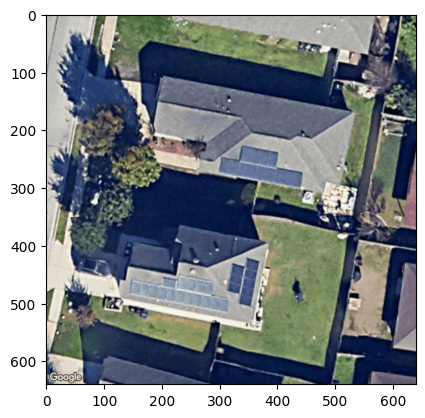

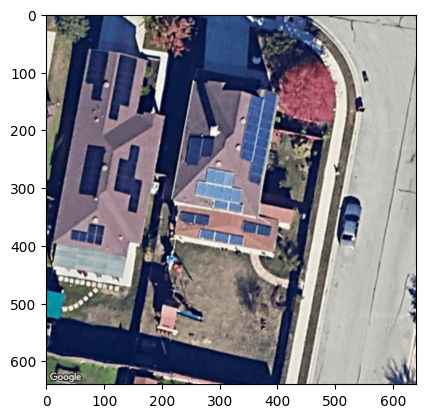

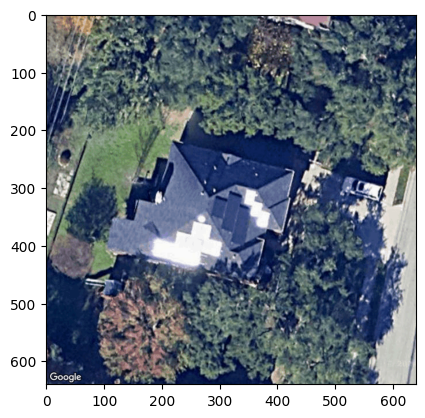

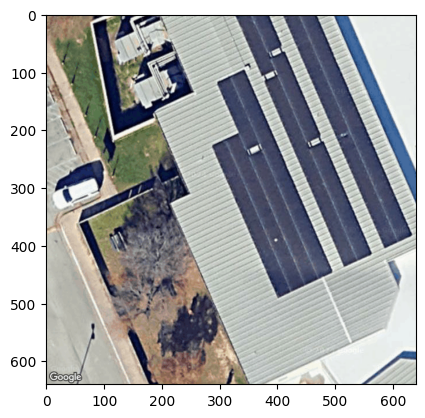

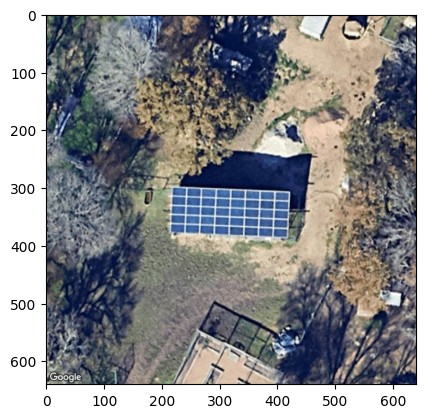

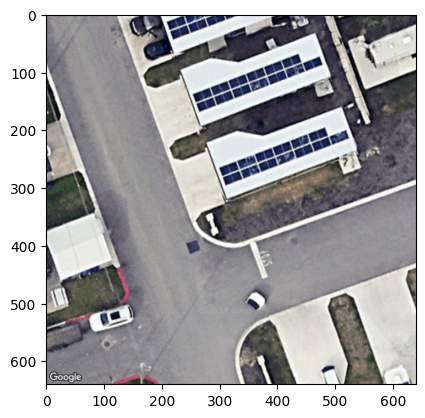

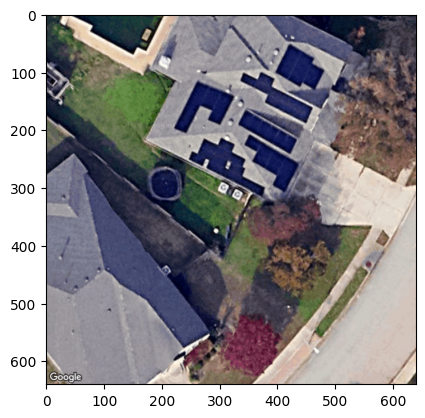

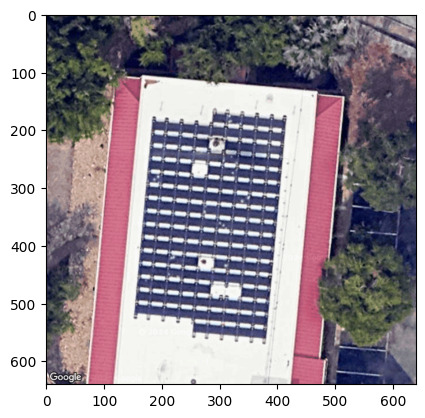

In [3]:
for image_file in example_images:
    img = Image.open(image_file)
    plt.imshow(img)
    plt.show()
    plt.close()

Let's load in the hail model.

In [4]:
cfg = Config.fromfile("./panel_segmentation/models/hail_config.py")
checkpoint_file = "./panel_segmentation/models/hail_model.pth"
model = init_detector(cfg, checkpoint_file, device='cpu')
visualizer = VISUALIZERS.build(model.cfg.visualizer)

C:\Users\kperry\.conda\envs\deep-learning\Lib\site-packages\mmcv\cnn\bricks\transformer.py:24: ImportWarning: ``MultiScaleDeformableAttention`` has been moved to ``mmcv.ops.multi_scale_deform_attn``, please change original path ``from mmcv.cnn.bricks.transformer import MultiScaleDeformableAttention`` to ``from mmcv.ops.multi_scale_deform_attn import MultiScaleDeformableAttention`` 
  warnings.warn(


Loads checkpoint by local backend from path: ./panel_segmentation/models/hail_model.pth


C:\Users\kperry\.conda\envs\deep-learning\Lib\site-packages\mmengine\runner\checkpoint.py:347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename

Next, lets run these images through the hail detection algorithms, and visualize our mask outputs.

c:\users\kperry\documents\source\repos\mmdetection\mmdet\models\layers\se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
c:\users\kperry\documents\source\repos\mmdetection\mmdet\models\backbones\csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
C:\Users\kperry\.conda\envs\deep-learning\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


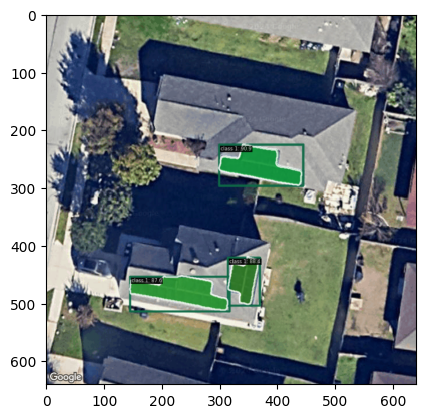

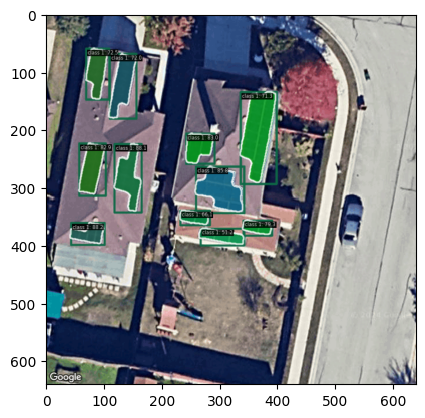

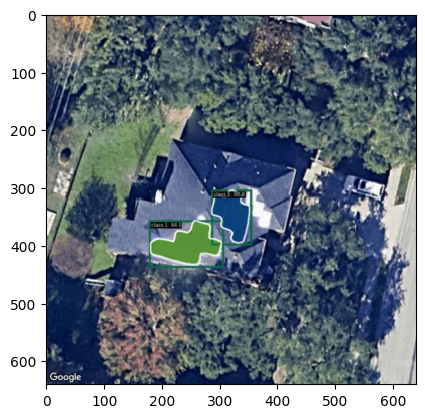

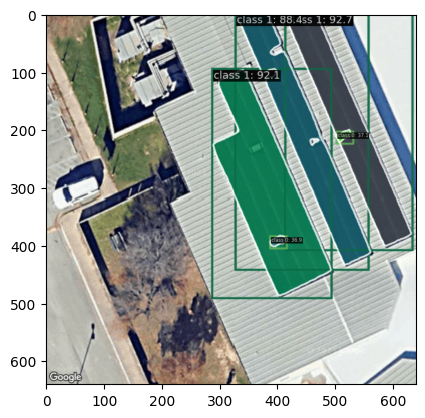

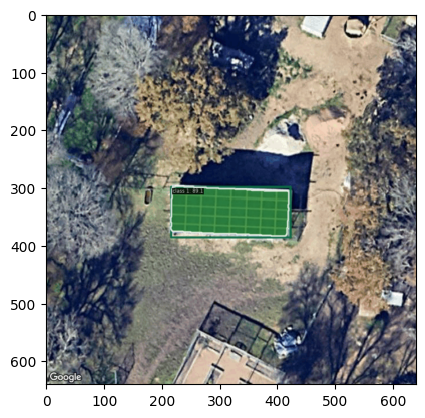

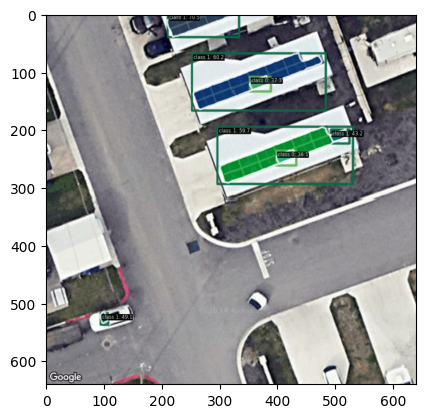

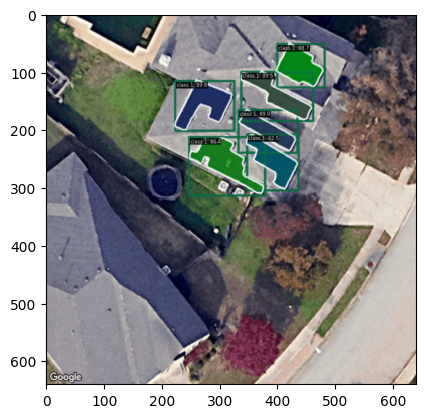

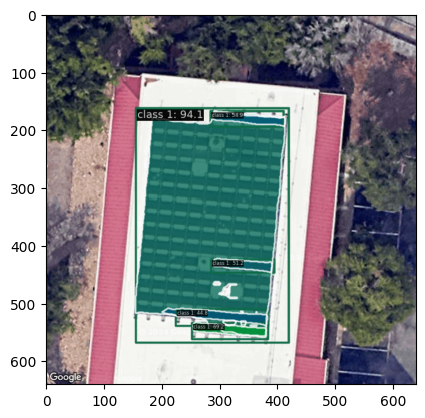

In [5]:
# Run inference on all of the example images
# Run inference on the example images
inference_data_list = list()
results = list()
for file in example_images:
    img = mmcv.imread(file, channel_order='rgb')
    new_result = inference_detector(model, img)
    visualizer.add_datasample(
          file,
          img,
          data_sample=new_result,
          draw_gt=None,
          wait_time=0,
          pred_score_thr=0.35
          )
    img = visualizer.get_image()
    plt.imshow(img)
    plt.show()
    plt.close()
    new_result.file = file
    results.append(new_result)

Let's calculate the percentage of hail damage by PV installation. 

In [6]:
inference_data_list = list()
for result in results:
    predictions = result._pred_instances
    masks = predictions.masks
    labels = predictions.labels
    scores = predictions.scores
    # Take all labels meeting a 0.3 threshold or greater
    idx_to_keep = np.argwhere(scores>=0.3).tolist()[0]
    file_name = os.path.basename(result.file)
    img_center_lat, img_center_lon = float(file_name.split("_")[0]), float(file_name.split("_")[-1].replace(".png", ""))
    image_x_pixels, image_y_pixels = new_result.img_shape
    # Convert all of the masks to latitude-longitude-based polygons
    for index in range(len(masks)):
            if index in idx_to_keep:
                segmentation_mask = masks[index].data.cpu().numpy()
                # Convert the mask to a polygon
                polygon_lat_lon_coords = utils.convertMaskToLatLonPolygon(segmentation_mask, 
                                                                    img_center_lat, 
                                                                    img_center_lon,
                                                                    image_x_pixels, 
                                                                    image_y_pixels,
                                                                    zoom_level=21)
                # Convert to a geoJSON
                shapely_poly = Polygon(polygon_lat_lon_coords)
                geojson_poly = geopandas.GeoSeries(shapely_poly).to_json()
                inference_data_list.append({"image": result.file,
                                            "poly": shapely_poly,
                                            "poly_centroid_lon": shapely_poly.centroid.x,
                                            "poly_centroid_lat": shapely_poly.centroid.y,
                                            "area": shapely_poly.area,
                                            "label": int(labels[index])})
inference_df = pd.DataFrame(inference_data_list)
inference_df.head(10)

image  \
0  ./panel_segmentation/examples/austin_hail_data...   
1  ./panel_segmentation/examples/austin_hail_data...   
2  ./panel_segmentation/examples/austin_hail_data...   
3  ./panel_segmentation/examples/austin_hail_data...   
4  ./panel_segmentation/examples/austin_hail_data...   
5  ./panel_segmentation/examples/austin_hail_data...   
6  ./panel_segmentation/examples/austin_hail_data...   
7  ./panel_segmentation/examples/austin_hail_data...   
8  ./panel_segmentation/examples/austin_hail_data...   
9  ./panel_segmentation/examples/austin_hail_data...   

                                                poly  poly_centroid_lon  \
0  POLYGON ((-97.74103527554185 30.14786232331778...         -97.741012   
1  POLYGON ((-97.74102907576999 30.14773298567980...         -97.741033   
2  POLYGON ((-97.74111664754747 30.14771087095414...         -97.741116   
3  POLYGON ((-97.74258986801313 30.14777252412872...         -97.742590   
4  POLYGON ((-97.74253407006641 30.14786299346098...         -97.742537   
5  POLYGON ((-97.74242867394484 30.14783685787610...         -97.742414   
6  POLYGON ((-97.74245347303227 30.14787505603861...         -97.742444   
7  POLYGON ((-97.74259064298461 30.14786366360418...         -97.742587   
8  POLYGON ((-97.74237907576999 30.14777587484473...         -97.742366   
9  POLYGON ((-97.74258444321276 30.14797356708930...         -97.742580   

   poly_centroid_lat          area  label  
0          30.147838  2.743164e-09      1  
1          30.147706  1.364830e-09      1  
2          30.147692  2.948044e-09      1  
3          30.147760  6.852716e-10      1  
4          30.147825  1.482202e-09      1  
5          30.147811  2.030107e-09      1  
6          30.147860  9.361137e-10      1  
7          30.147835  1.283034e-09      1  
8          30.147767  4.411809e-10      1  
9          30.147947  1.089579e-09      1

In [7]:
# Filter to just modules (label == 1)
inference_df_modules = inference_df[inference_df['label'] == 1]
dmg_list = list()

for idx, row in inference_df_modules.iterrows():
    polygon = row['poly']
    # Get all of the potential overlapping modules
    other_masks = inference_df[inference_df['image'].str.contains(os.path.basename(row['image']))]
    other_masks = other_masks[other_masks['label'] == 0]
    total_dmg_amt = 0
    for idx2, row2 in other_masks.iterrows():
        sub_polygon = row2['poly']
        sub_label = row2['label']
        try:
            if sub_polygon.intersects(polygon):
                # Check if the small polygon is entirely within the large polygon.
                # If it's labeled 0, mark it as a duplicate and remove
                if ((sub_polygon.intersection(polygon).area/sub_polygon.area) * 100) > 90:
                    #plt.plot(*sub_polygon.exterior.xy)
                    # if this is a damage flag, check how much overlap there is for damage
                    if sub_label == 0:
                        dmg_pct = ((sub_polygon.area/
                                    polygon.area) * 100)
                        total_dmg_amt = total_dmg_amt + dmg_pct
        except:
            pass
    row_dict = row.to_dict()
    row_dict['total_damage_amt'] = total_dmg_amt
    dmg_list.append(row_dict)

dmg_df = pd.DataFrame(dmg_list)

# Visualize the dataframe, sorted by level of damage
dmg_df.sort_values(by=['total_damage_amt'], ascending=False).head(10)

image  \
22  ./panel_segmentation/examples/austin_hail_data...   
23  ./panel_segmentation/examples/austin_hail_data...   
17  ./panel_segmentation/examples/austin_hail_data...   
18  ./panel_segmentation/examples/austin_hail_data...   
21  ./panel_segmentation/examples/austin_hail_data...   
24  ./panel_segmentation/examples/austin_hail_data...   
25  ./panel_segmentation/examples/austin_hail_data...   
26  ./panel_segmentation/examples/austin_hail_data...   
27  ./panel_segmentation/examples/austin_hail_data...   
28  ./panel_segmentation/examples/austin_hail_data...   

                                                 poly  poly_centroid_lon  \
22  POLYGON ((-97.69201056921564 30.48716887608689...         -97.692071   
23  POLYGON ((-97.69197946285585 30.48708242761384...         -97.692036   
17  POLYGON ((-97.80182947688024 30.14901444582462...         -97.801743   
18  POLYGON ((-97.80188605037192 30.14894877179083...         -97.801851   
21  POLYGON ((-97.69216532335552 30.48721444582462...         -97.692151   
24  POLYGON ((-97.69227264029676 30.48686865193241...         -97.692271   
25  POLYGON ((-97.69194835649608 30.48707974704103...         -97.691955   
26  POLYGON ((-97.69225475413988 30.48687066236202...         -97.692256   
27  POLYGON ((-97.69198490646882 30.48716552537088...         -97.691990   
28  POLYGON ((-97.7221735595942 30.487073715752214...         -97.722144   

    poly_centroid_lat          area  label  total_damage_amt  
22          30.487137  3.510158e-09      1         13.473387  
23          30.487052  3.492439e-09      1          6.714915  
17          30.148883  1.148328e-08      1          1.368097  
18          30.148807  1.765235e-08      1          0.920873  
21          30.487204  1.271589e-09      1          0.000000  
24          30.486862  8.468572e-11      1          0.000000  
25          30.487072  1.972526e-10      1          0.000000  
26          30.486866  7.660800e-11      1          0.000000  
27          30.487158  1.923017e-10      1          0.000000  
28          30.487043  1.776576e-09      1          0.000000

Let's visualize the images that were flagged for hail-related damage.

c:\users\kperry\documents\source\repos\mmdetection\mmdet\models\layers\se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
c:\users\kperry\documents\source\repos\mmdetection\mmdet\models\backbones\csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


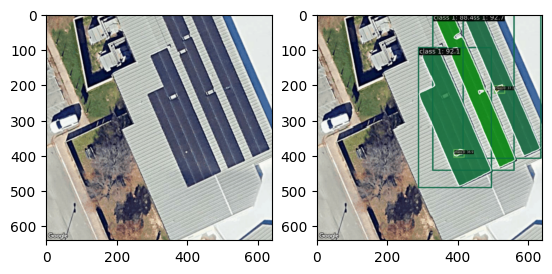

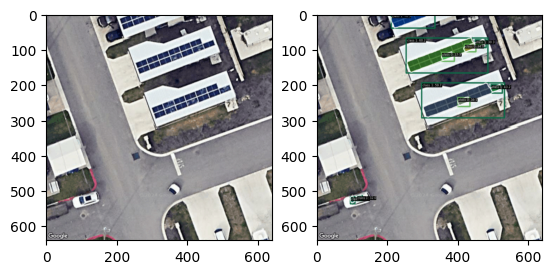

In [8]:
dmg_df = dmg_df[dmg_df['total_damage_amt']>0]
dmg_images = list(dmg_df['image'].drop_duplicates())
for img_path in dmg_images:
    img = mmcv.imread(img_path, channel_order='rgb')
    new_result = inference_detector(model, img)
    visualizer.add_datasample(
          img_path,
          img,
          data_sample=new_result,
          draw_gt=None,
          wait_time=0
          )
    img_infer = visualizer.get_image()
    # Create subplots to visualize the original image + inference image side-by-side
    plt.subplot(1, 2, 1)
    img_orig = mmcv.imread(img_path, channel_order='rgb')
    plt.imshow(img_orig)
    plt.subplot(1, 2, 2)
    plt.imshow(img_infer)
    plt.show()
    plt.close()